In [33]:
import os
import pydicom
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider
from skimage.filters import gaussian
from skimage.exposure import equalize_adapthist
from scipy.ndimage import gaussian_filter1d
from scipy.signal import deconvolve

In [34]:
dcm_path = '/Users/juntangwang/Desktop/SRS00013/IMG00001.DCM'
folder_path = '/Users/juntangwang/Desktop/SRS00013/'  # Update this to the path of your DICOM folder

In [36]:
def time_to_seconds(t):
    """Converts a time string in HHMMSS.fff format to seconds."""
    hours, minutes, seconds = int(t[:2]), int(t[2:4]), float(t[4:])
    return 3600 * hours + 60 * minutes + seconds

dicom_files = [f for f in os.listdir(folder_path) if f.endswith('.DCM')]

# Initialize a list to hold your image data
image_data = []
acquisition_times = []
image_positions = []

acquisition_numbers =[]
instance_numbers = []

for file in dicom_files:
    file_path = os.path.join(folder_path, file)
    ds = pydicom.dcmread(file_path)
    
    # Preprocess the image as necessary. This is just a placeholder for any actual preprocessing you need to do.
    # For example: image = preprocess(ds.pixel_array)
    # image_data.append(equalize_adapthist(gaussian(ds.pixel_array, sigma=1)))
    image_data.append(ds.pixel_array)
    
    # Extract acquisition time; note that you'll need to adjust 'AcquisitionTime' based on your DICOM files' metadata structure
    acquisition_times.append(time_to_seconds(ds.AcquisitionTime))
    image_positions.append(ds.ImagePositionPatient)
    
    acquisition_numbers.append(ds.AcquisitionNumber)
    instance_numbers.append(ds.InstanceNumber)
    
image_data = np.array(image_data)
image_positions = np.array(image_positions)
acquisition_times = np.array(acquisition_times)

# Assuming these are your original lists:
# image_data = [np.array(...) for _ in range(1000)]  # Each a 256x256 numpy array
# image_position = [np.array(...) for _ in range(1000)]  # Each a 1x3 numpy array
# acquisition_time = [np.random.rand() for _ in range(1000)]  # Each a random float

# Step 1: Combine the lists into a single list of tuples
combined = list(zip(image_data, image_positions, acquisition_times, acquisition_numbers, instance_numbers))

# combined.sort(key=lambda x: x[-1])

combined.sort(key=lambda x: x[2])
# Step 2: Sort the combined list by the image_position (assuming it's the second element of the tuple)
combined.sort(key=lambda x: x[1][1])  # Adjust the lambda function if sorting criteria are different

# Step 3: Separate the combined list back into three lists
image_data_sorted, image_position_sorted, acquisition_time_sorted, acquisition_numbers_sorted, instance_numbers_sorted = zip(*combined)

# If you need the results to be in list format instead of tuples (especially for the image data), you can convert them
# image_data_sorted = list(equalize_adapthist(gaussian(np.array(image_data_sorted) , sigma=1)))
image_data_sorted = list(image_data_sorted)
image_position_sorted = list(image_position_sorted)
acquisition_time_sorted = list(acquisition_time_sorted)
acquisition_numbers_sorted = list(acquisition_numbers_sorted)
instance_numbers_sorted = list(instance_numbers_sorted)

RT: 1590
TE: 32
flip angle: 90

a = []
for i in range(len(image_data_sorted)):
    a.append(i)
    
a = np.asarray(a)
# Assuming image_position and image_position_sorted are your original and sorted position lists respectively

# Convert lists to numpy arrays for easier slicing
original_positions = np.array(image_positions)
sorted_positions = np.array(image_position_sorted)

# Before sorting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(a[:], original_positions[:, 1], alpha=0.6)
plt.title('Before Sorting')
plt.xlabel('X')
plt.ylabel('Y')

# After sorting
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(a[:], sorted_positions[:, 1], alpha=0.6)
plt.title('After Sorting')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

a = []
for i in range(len(image_data_sorted)):
    a.append(i)
    
a = np.asarray(a)
# Assuming image_position and image_position_sorted are your original and sorted position lists respectively

# Convert lists to numpy arrays for easier slicing
original_positions = np.array(instance_numbers)
sorted_positions = np.array(instance_numbers_sorted)

# Before sorting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(a[:], original_positions[:], alpha=0.6)
plt.title('Before Sorting')
plt.xlabel('X')
plt.ylabel('Y')

# After sorting
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(a[:], sorted_positions[:], alpha=0.6)
plt.title('After Sorting')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

In [37]:
def intensity_to_concentration(intensity, baseline=None):
    
    if baseline is None:
        baseline = np.average(intensity[6:8]) #TODO: Baseline modeling
    
    baseline = baseline + np.min(baseline)
    
    # Placeholder values for demonstration
    te = 32  # Echo time in milliseconds (ms)
    s0 = baseline  # Baseline signal intensity before contrast injection
    st = intensity  # Signal intensity at different times after contrast injection

    # Calculating contrast agent concentration using the provided formula
    # ct = (1/te) * np.log(st/s0)
    ct = st
    return ct

def plt_point(x,y,z,view=False):
    times = acquisition_time_sorted[50*(z-1):50*z]-acquisition_time_sorted[50*(z-1)]
    concentrations = intensity_to_concentration(image_data_sorted[50*(z-1):50*z,x,y])
    if view:
        print("InstanceNumbers: ")
        print(instance_numbers_sorted[50*(z-1):50*z])
        print("AcquisitionNumbers: ")
        print(acquisition_numbers_sorted[50*(z-1):50*z])
        print("unique image_positions: ")
        print(np.unique(image_position_sorted[50*(z-1):50*z]))
    
    # Assuming 'concentration' and 'time_points' are your data arrays
    plt.figure(figsize=(10, 6))
    plt.plot(times, concentrations, '-o', label='Concentration over Time')
    plt.title(f'Concentration vs. Time at <{x},{y},{z}>*\n*: not exact position, x,y is pixel index & z is slice index')
    plt.xlabel('Time Point (s)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Interactive visualization of 3D data over time
def explore_3dimage_time(i=0,z=0,x=0,y=0,vis=False,aif=False):
    if vis:
        i = (z-1)*50+i
        plt.figure(figsize=(10, 5))
        plt.imshow(image_data_sorted[i, :, :], cmap='gray')  # Adjust the 15 here to show different slices
        plt.title(f'#: {instance_numbers_sorted[i]} Position: {image_position_sorted[i]} \n T#: {acquisition_numbers_sorted[i]} Time: {acquisition_time_sorted[i]}')
        plt.axis('off')
        plt.scatter(x, y, color='red', s=10)  # Highlight the point
        plt.show()
    if aif: 
        plt_point(x,y,z)

In [38]:
# Assuming 'image_series' is a 4D numpy array [time, z, x, y]
# where 'time' is the 4th dimension (different acquisition times)
image_data_sorted = np.array(image_data_sorted)

# Create a slider to move through time
interact(explore_3dimage_time, 
         i=IntSlider(min=0, max=49, step=1, value=0), 
         z=IntSlider(min=1,max=20,step=1, value=1),
         x=IntSlider(min=0, max=255, step=1),
         y=IntSlider(min=0, max=255, step=1),
         vis=True,
         aif=True)


interactive(children=(IntSlider(value=0, description='i', max=49), IntSlider(value=1, description='z', max=20,…

<function __main__.explore_3dimage_time(i=0, z=0, x=0, y=0, vis=False, aif=False)>

C(t) =(1/TE)*ln(S(t)/S0), where TE is the echo time, S(t) is the signal intensity at each timepoint during the gamma fitting period and S0 is the average baseline signal intensity

In [39]:
def smooth_data_gaussian(data, sigma=1):
    """
    Smooths the data using a Gaussian filter.

    :param data: The input data to smooth.
    :param sigma: The standard deviation for the Gaussian kernel.
    :return: The smoothed data.
    """
    return gaussian_filter1d(data, sigma)

def plt_pointss(xyztuples=None, view=False, smooth=False, legend_on=False):
    if xyztuples is None:
        xyztuples = [(0, 0, 0)]
    plt.figure(figsize=(10, 6))
    
    for i, (x, y, z) in enumerate(xyztuples):
        times = acquisition_time_sorted[50*(z-1):50*z] - acquisition_time_sorted[50*(z-1)]
        concentrations = intensity_to_concentration(image_data_sorted[50*(z-1):50*z,x,y])
        
        # Smooth the concentration data using Gaussian filter
        if smooth:
            smoothed_concentrations = smooth_data_gaussian(concentrations)
        else:
            smoothed_concentrations = concentrations.copy()

        if view:
            print(f"Data for {x},{y},{z}")
            print("InstanceNumbers: ")
            print(instance_numbers_sorted[50*(z-1):50*z])
            print("AcquisitionNumbers: ")
            print(acquisition_numbers_sorted[50*(z-1):50*z])
            print("unique image_positions: ")
            print(np.unique(image_position_sorted[50*(z-1):50*z]))
            print()  # Print a newline for readability
        
        plt.plot(times, smoothed_concentrations, '-o', label=f'<{x},{y},{z}>')
    
    plt.title('Smoothed Concentration vs. Time for Multiple Points\n*: not exact position, x,y is pixel index & z is slice index')
    plt.xlabel('Time Point (s)')
    plt.ylabel('Concentration')
    if legend_on:    
        plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# xyztuples = [(x1, y1, z1), (x2, y2, z2), ...]
# plt_points(xyztuples, view=True)

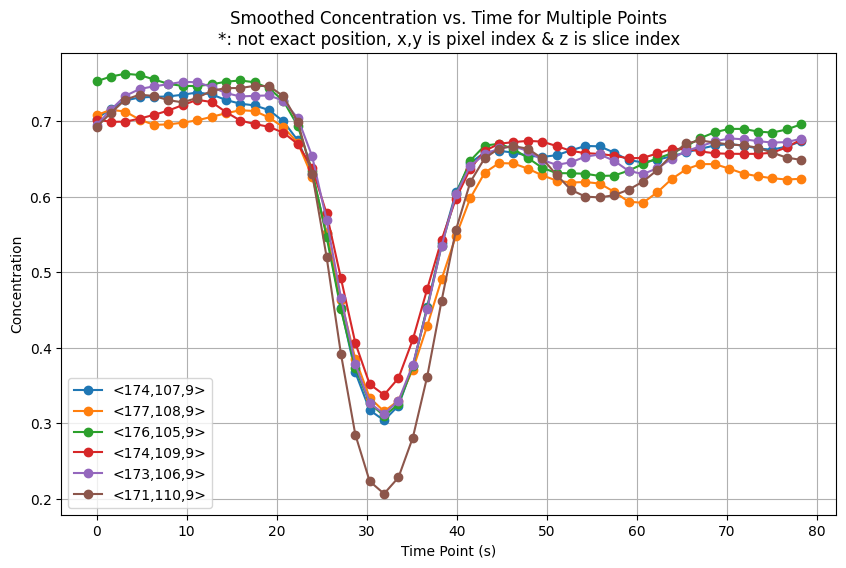

In [40]:
xyztuples = [  
    (174,107,9),
    (177,108,9),
    (176,105,9),
    (174,109,9),
    (173,106,9),
    (171,110,9)
    ]
plt_pointss(xyztuples,smooth=True, legend_on=True)


In [41]:
def test_around(x0,y0,z0,r=5,s=False, l=False):
    xyztuples=[]
    for x in range(x0-r,x0+r+1):
        for y in range(y0-r,y0+r+1):
            xyztuples.append((x,y,z0))
    plt_pointss(xyztuples, smooth=s, legend_on=l)

r = 3

interact(test_around,
         z0=IntSlider(min=1,max=20,step=1, value=1),
         x0=IntSlider(min=r, max=255-r, step=1),
         y0=IntSlider(min=r, max=255-r, step=1),
         r=r,
         l=False
         )

interactive(children=(IntSlider(value=3, description='x0', max=252, min=3), IntSlider(value=3, description='y0…

<function __main__.test_around(x0, y0, z0, r=5, s=False, l=False)>

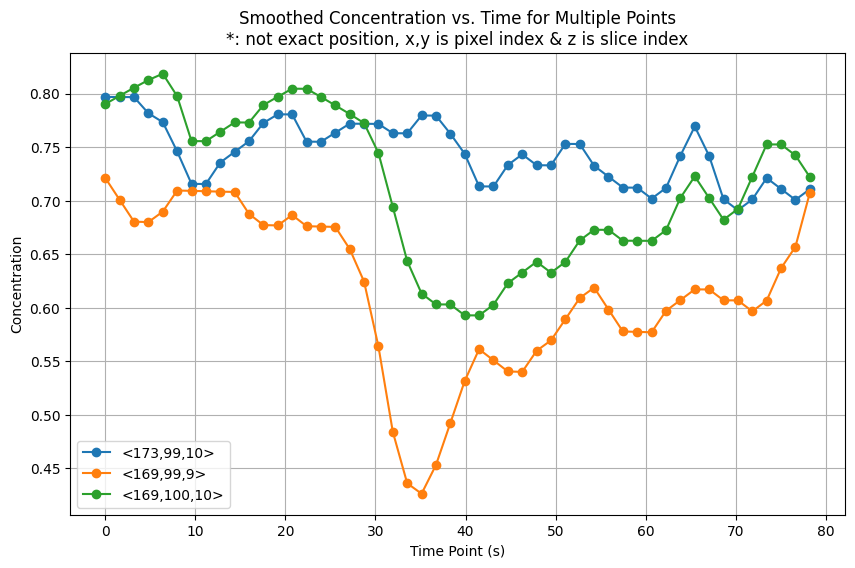

In [42]:
xyztuples = [
    (173,99,10),
    (169,99,9),
    (169,100,10),
    ]
plt_pointss(xyztuples, legend_on=True)

In [43]:
def read_point4time(x,y,z):
    """Read time points for a given slice."""
    return acquisition_time_sorted[50*(z-1):50*z] - acquisition_time_sorted[50*(z-1)]

def read_point4concentration(x, y, z):
    """Read concentration data for a given point."""
    return intensity_to_concentration(image_data_sorted[50*(z-1):50*z, x, y])
    
    

R(t): [1.1345944]
Tissue blood flow (F): 0.8320358918394568


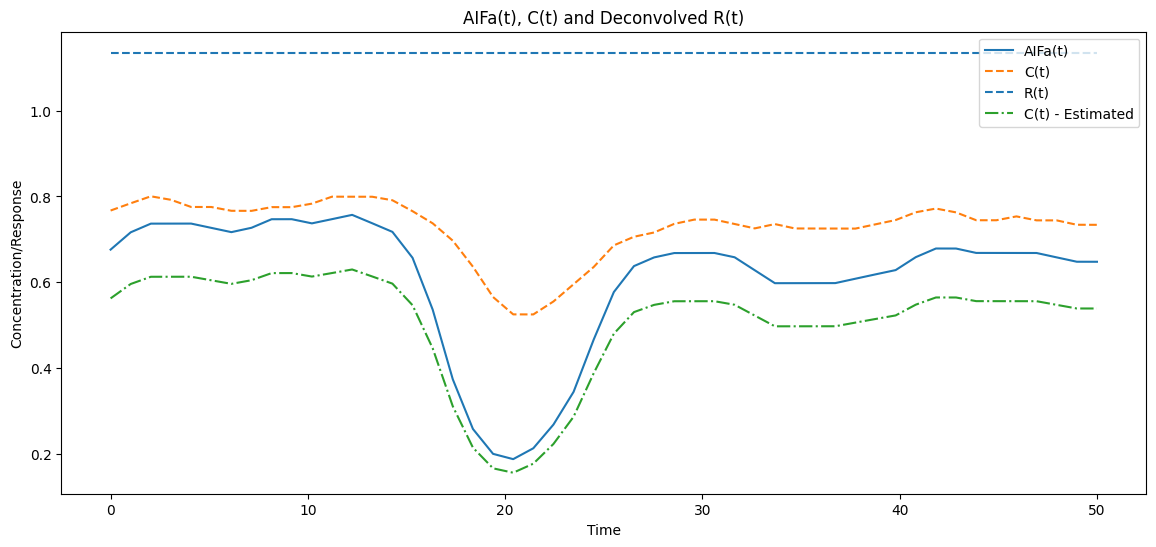

In [44]:
def calculate_R_F_for_multiple_tissue_points(aif_pixel, tissue_pixel):
    """
    Calculate R(t) and F for multiple tissue points.
    
    :param aif_pixel: Tuple containing the coordinates of the AIF pixel (x, y, z).
    :param tissue_pixels: List of tuples, each containing the coordinates of a tissue pixel (x, y, z).
    :return: A dictionary with tissue point coordinates as keys and (R_t, F) tuples as values.
    """
    tissue_concentration = read_point4concentration(*tissue_pixel)
    aif_concentration = read_point4concentration(*aif_pixel)
    
    # Define the hematocrit correction factor kH
    Ha = 0.45  # Typical arterial hematocrit
    Ht = 0.25  # Typical tissue hematocrit        
    kH = (1 - Ha) / (1 - Ht)
        
    # Apply deconvolution
    R_t, remainder = deconvolve(tissue_concentration, aif_concentration)
    F = np.sum(R_t) * kH  # Adjusted calculation for F
            
    return R_t, F

# Example usage
aif_pixel = (171, 110, 9)  # AIF pixel coordinates
tissue_pixel = (173, 103,10)

R_t, F= calculate_R_F_for_multiple_tissue_points(aif_pixel, tissue_pixel)

print(f"R(t):", R_t)
print(f"Tissue blood flow (F):", F)

C = np.convolve(read_point4concentration(*aif_pixel), R_t, mode='full')

time = np.linspace(0, 50, 50)
time0 = np.linspace(0,50, 99)

# Define the hematocrit correction factor kH
Ha = 0.45  # Typical arterial hematocrit
Ht = 0.25  # Typical tissue hematocrit        
kH = (1 - Ha) / (1 - Ht)

plt.figure(figsize=(14, 6))
plt.plot(time, read_point4concentration(*aif_pixel), label='AIFa(t)')
plt.plot(time, read_point4concentration(*tissue_pixel), label='C(t)', linestyle='--')
plt.hlines(R_t,xmin=0,xmax=50,label='R(t)', linestyle='--')
plt.plot(time, C*kH, label='C(t) - Estimated', linestyle='-.')
plt.xlabel('Time')
plt.ylabel('Concentration/Response')
plt.legend()
plt.title('AIFa(t), C(t) and Deconvolved R(t)')
plt.show()

In [45]:
print(read_point4concentration(tissue_pixel[0], tissue_pixel[1], tissue_pixel[2]))

[0.76714013 0.78404968 0.80028285 0.79210478 0.77544119 0.7753797
 0.76652524 0.76640226 0.77507225 0.77494927 0.78318883 0.799422
 0.79929902 0.79923753 0.79105946 0.7656029  0.73737933 0.69691939
 0.63635246 0.56576277 0.52536432 0.52524135 0.55537109 0.59558507
 0.63573756 0.68603579 0.70608129 0.71604255 0.73608805 0.74604931
 0.74598783 0.73578061 0.72557339 0.73559614 0.72538892 0.72526594
 0.72520445 0.72508147 0.73504274 0.745004   0.76308184 0.77175183
 0.76283589 0.74457357 0.74451208 0.75348952 0.74426613 0.74420464
 0.73399742 0.73387444]


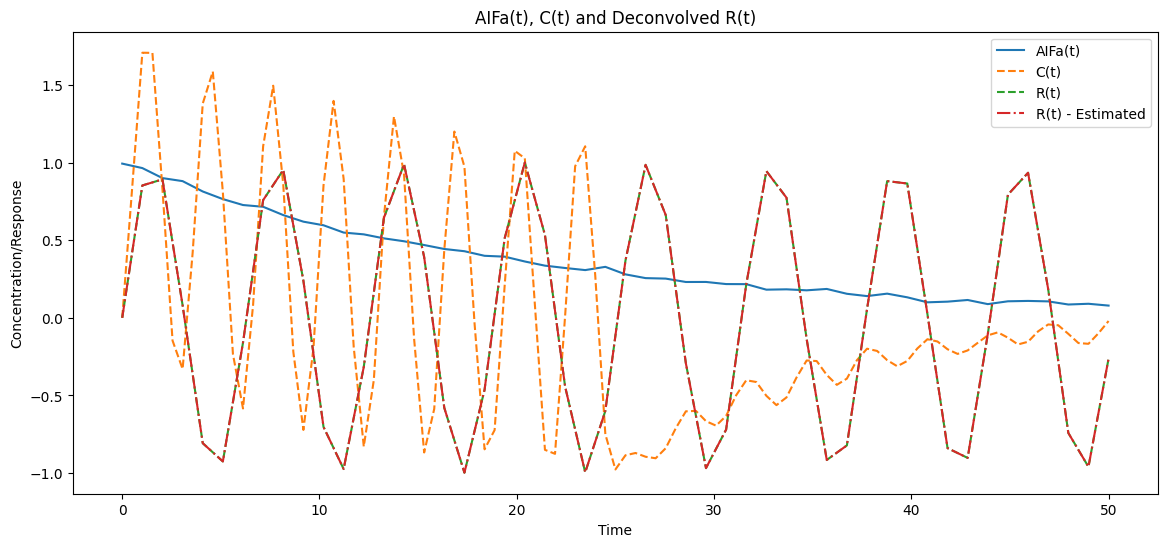

In [46]:
from scipy.signal import deconvolve
from scipy.signal import convolve

# Time array
time = np.linspace(0, 50, 50)
time1 = np.linspace(0,50,99)

R_t = np.sin(time)

# Simulate AIFa(t) as an exponential decay function
AIFa = np.exp(-0.05 * time) + np.random.normal(0, 0.01, len(time))

# Simulate C(t) as a scaled and delayed version of AIFa(t)
C = convolve(AIFa, R_t, mode='full')

quotient, reminder = deconvolve(C, AIFa)

R = quotient

plt.figure(figsize=(14, 6))
plt.plot(time, AIFa, label='AIFa(t)')
plt.plot(time1, C, label='C(t)', linestyle='--')
plt.plot(time, R_t,label='R(t)', linestyle='--')
plt.plot(time, R, label='R(t) - Estimated', linestyle='-.')
plt.xlabel('Time')
plt.ylabel('Concentration/Response')
plt.legend()
plt.title('AIFa(t), C(t) and Deconvolved R(t)')
plt.show()
